<a href="https://colab.research.google.com/github/slouxjiwon/ITB/blob/main/1910621_%EC%9D%B4%EC%A7%80%EC%9B%90__%EC%95%84%EB%B9%84%ED%98%81_%EB%B6%84%EB%A5%98_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install mglearn 
!pip install --upgrade joblib==1.1.0
import mglearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

plt.rc('font', family='NanumGothic') 
plt.rc("axes", unicode_minus=False)

import matplotlib
matplotlib.font_manager._rebuild()

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ITB/health_data.csv", encoding="UTF-8")

종속(목표) 변수 : 음주 여부

건강검진의 음주 여부 이외의 설명 변수로 음주 여부를 예측해보고자 함. 음주 여부가 예측이 될시, 음주가 사람의 건강에 미치는 (부정적)영향을 명확히 드러낼 수 있을 것이라 기대

사용 모델 : 의사결정 나무(+앙상블)

미리 인터넷 검색으로 음주 여부는 간 기능에 영향을 미치며, 따라서 주요 설명변수에는 총콜레스테롤, 트리글리세라이드, HDL, LDL, 혈당, 체지방률(BMI)이 포함될 것이라 예측

In [7]:
print(df.columns)
display(df.info())
display(df.head())

Index(['기준년도', '가입자일련번호', '시도코드', '성별코드', '연령대코드(5세단위)', '신장(5Cm단위)',
       '체중(5Kg 단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '치석', '데이터공개일자'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   기준년도         10000 non-null  int64  
 1   가입자일련번호      10000 non-null  int64  
 2   시도코드         10000 non-null  int64  
 3   성별코드         10000 non-null  object 
 4   연령대코드(5세단위)  10000 non-null  int64  
 5   신장(5Cm단위)    10000 non-null  int64  
 6   체중(5Kg 단위)   10000 non-null  int64  
 7   허리둘레         10000 non-null  float64
 8   시력(좌)        10000 non-null  float64
 9   시력(우)        10000 non-null  float64
 10  청력(좌)   

None

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석,데이터공개일자
0,2020,1,36,M,9,165,60,72.1,1.2,1.5,...,1.1,21.0,27.0,21.0,No,No,0,NaN,NaN,12/29/2021
1,2020,2,27,F,13,150,65,81.0,0.8,0.8,...,0.5,18.0,15.0,15.0,No,No,0,NaN,NaN,12/29/2021
2,2020,3,11,F,12,155,55,70.0,0.6,0.7,...,0.7,27.0,25.0,7.0,No,No,0,NaN,NaN,12/29/2021
3,2020,4,31,M,13,160,70,90.8,1.0,1.0,...,1.2,65.0,97.0,72.0,No,No,1,0.0,0.0,12/29/2021
4,2020,5,41,F,12,155,50,75.2,1.5,1.2,...,0.7,18.0,17.0,14.0,No,No,0,NaN,NaN,12/29/2021


In [8]:
df.describe() 
#결측치를 어떻게 채울지 기준을 확인

,기준년도,가입자일련번호,시도코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,구강검진수검여부,치아우식증유무,치석
count,10000.0,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,3977.000000,9912.000000,9861.000000,9912.000000,9912.00000,9912.000000,9912.000000,10000.000000,3251.000000,3251.000000
mean,2020.0,5000.50000,34.100100,11.931400,160.983500,63.034500,82.366100,0.933750,0.936750,1.050500,...,116.263264,14.214255,1.119461,0.848484,27.58979,26.789851,38.098668,0.325100,0.175331,0.579514
std,0.0,2886.89568,12.394581,2.166048,9.211608,12.205294,9.561973,0.662057,0.641378,0.227936,...,37.829955,1.555386,0.489782,0.301012,17.88442,23.735687,58.184579,0.468436,0.380308,0.591269
min,2020.0,1.00000,11.000000,9.000000,130.000000,30.000000,53.000000,0.100000,0.100000,1.000000,...,13.000000,5.100000,1.000000,0.050000,3.00000,2.000000,3.000000,0.000000,0.000000,0.000000
25%,2020.0,2500.75000,27.000000,10.000000,155.000000,55.000000,76.000000,0.700000,0.700000,1.000000,...,89.000000,13.200000,1.000000,0.700000,20.00000,16.000000,16.000000,0.000000,0.000000,0.000000
50%,2020.0,5000.50000,41.000000,12.000000,160.000000,60.000000,82.000000,0.900000,0.900000,1.000000,...,115.000000,14.200000,1.000000,0.800000,24.00000,21.000000,24.000000,0.000000,0.000000,1.000000
75%,2020.0,7500.25000,44.000000,13.000000,170.000000,70.000000,88.900000,1.200000,1.200000,1.000000,...,141.000000,15.300000,1.000000,1.000000,30.00000,31.000000,39.000000,1.000000,0.000000,1.000000
max,2020.0,10000.00000,49.000000,18.000000,195.000000,130.000000,134.000000,9.900000,9.900000,3.000000,...,297.000000,20.000000,6.000000,9.200000,692.00000,1146.000000,2322.000000,1.000000,1.000000,2.000000


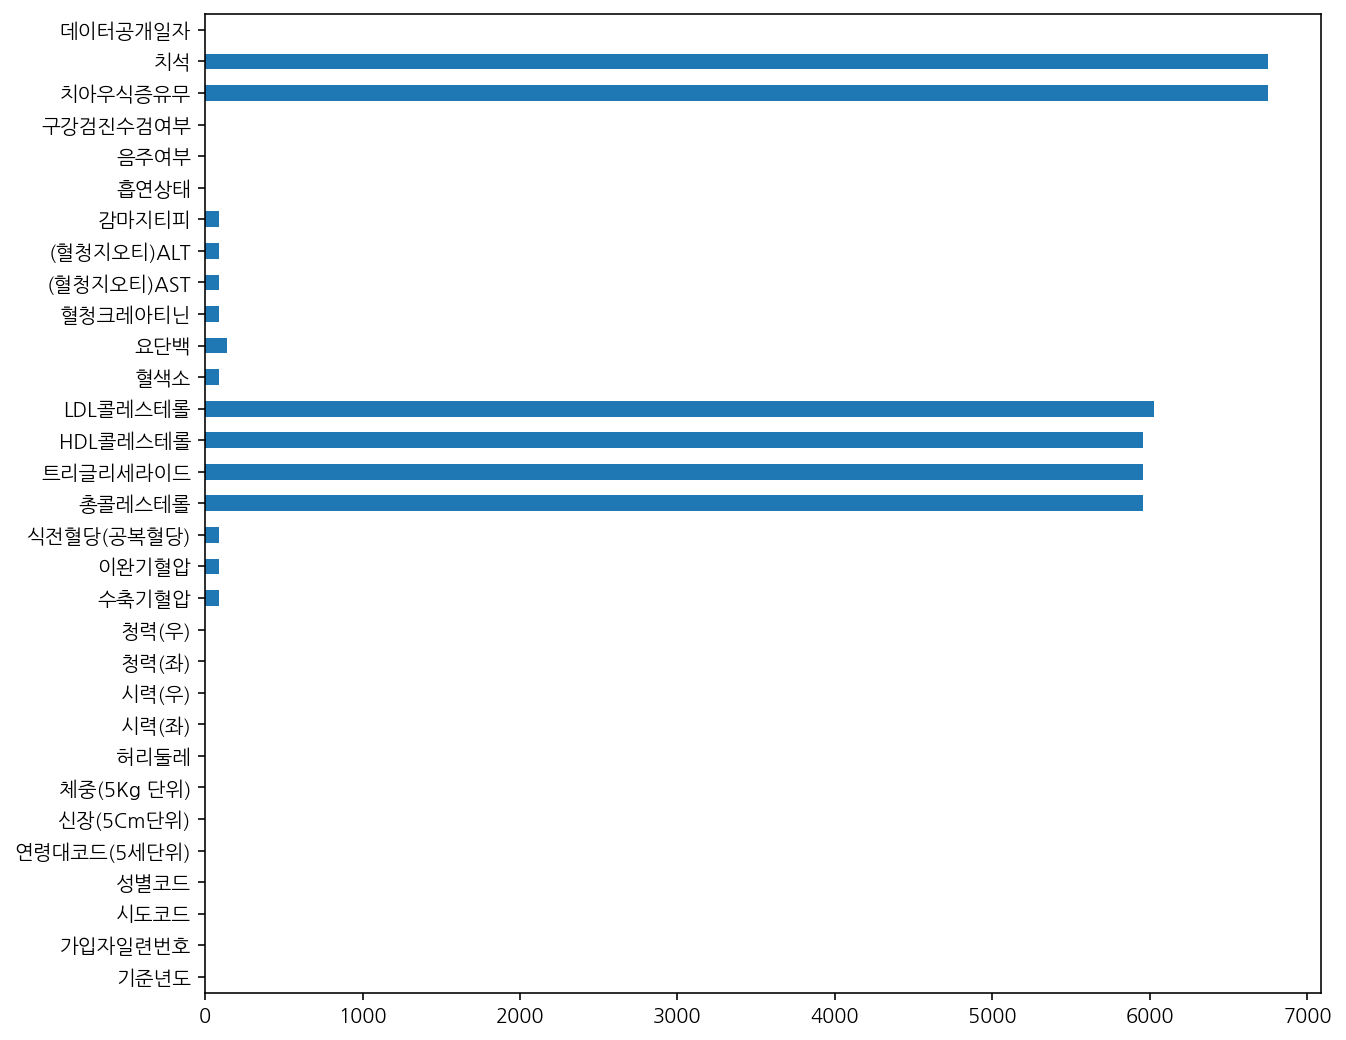

In [9]:
df.isnull().sum().plot.barh(figsize=(10, 9)) #결측치 확인

In [10]:
df_1 = df.drop(['치석','치아우식증유무','구강검진수검여부','데이터공개일자','가입자일련번호','기준년도','시도코드'], axis=1)
#결측치가 높은 치석, 치아우식증 유무와, 음주 여부와 연관 없는 열 삭제

In [11]:
df_1.columns #남은 열 확인
#감마지티피, 혈청지오티, 혈청크레아티닌, 요단백, 혈색소, 콜레스테롤, 혈당, 혈압 보간 필요

Index(['성별코드', '연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '시력(좌)',
       '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤',
       '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부'],
      dtype='object')

In [12]:
#요단백을 제외한 다른 수치는 평균값으로 보간
#요단백은 가장 많이 나온 1 값으로 보간
df_1.fillna({'감마지티피':int(df_1['감마지티피'].mean())}, inplace=True)
df_1.fillna({'(혈청지오티)AST':int(df_1['(혈청지오티)AST'].mean())}, inplace=True)
df_1.fillna({'(혈청지오티)ALT':int(df_1['(혈청지오티)ALT'].mean())}, inplace=True)
df_1.fillna({'혈청크레아티닌':int(df_1['혈청크레아티닌'].mean())}, inplace=True)
df_1.fillna({'혈색소':int(df_1['혈색소'].mean())}, inplace=True)
df_1.fillna({'HDL콜레스테롤':int(df_1['HDL콜레스테롤'].mean())}, inplace=True)
df_1.fillna({'LDL콜레스테롤':int(df_1['LDL콜레스테롤'].mean())}, inplace=True)
df_1.fillna({'트리글리세라이드':int(df_1['트리글리세라이드'].mean())}, inplace=True)
df_1.fillna({'식전혈당(공복혈당)':int(df_1['식전혈당(공복혈당)'].mean())}, inplace=True)
df_1.fillna({'이완기혈압':int(df_1['이완기혈압'].mean())}, inplace=True)
df_1.fillna({'수축기혈압':int(df_1['수축기혈압'].mean())}, inplace=True)
df_1.fillna({'총콜레스테롤':int(df_1['총콜레스테롤'].mean())}, inplace=True)
df_1.loc[df_1['요단백'] != df_1['요단백'], '요단백'] = 1

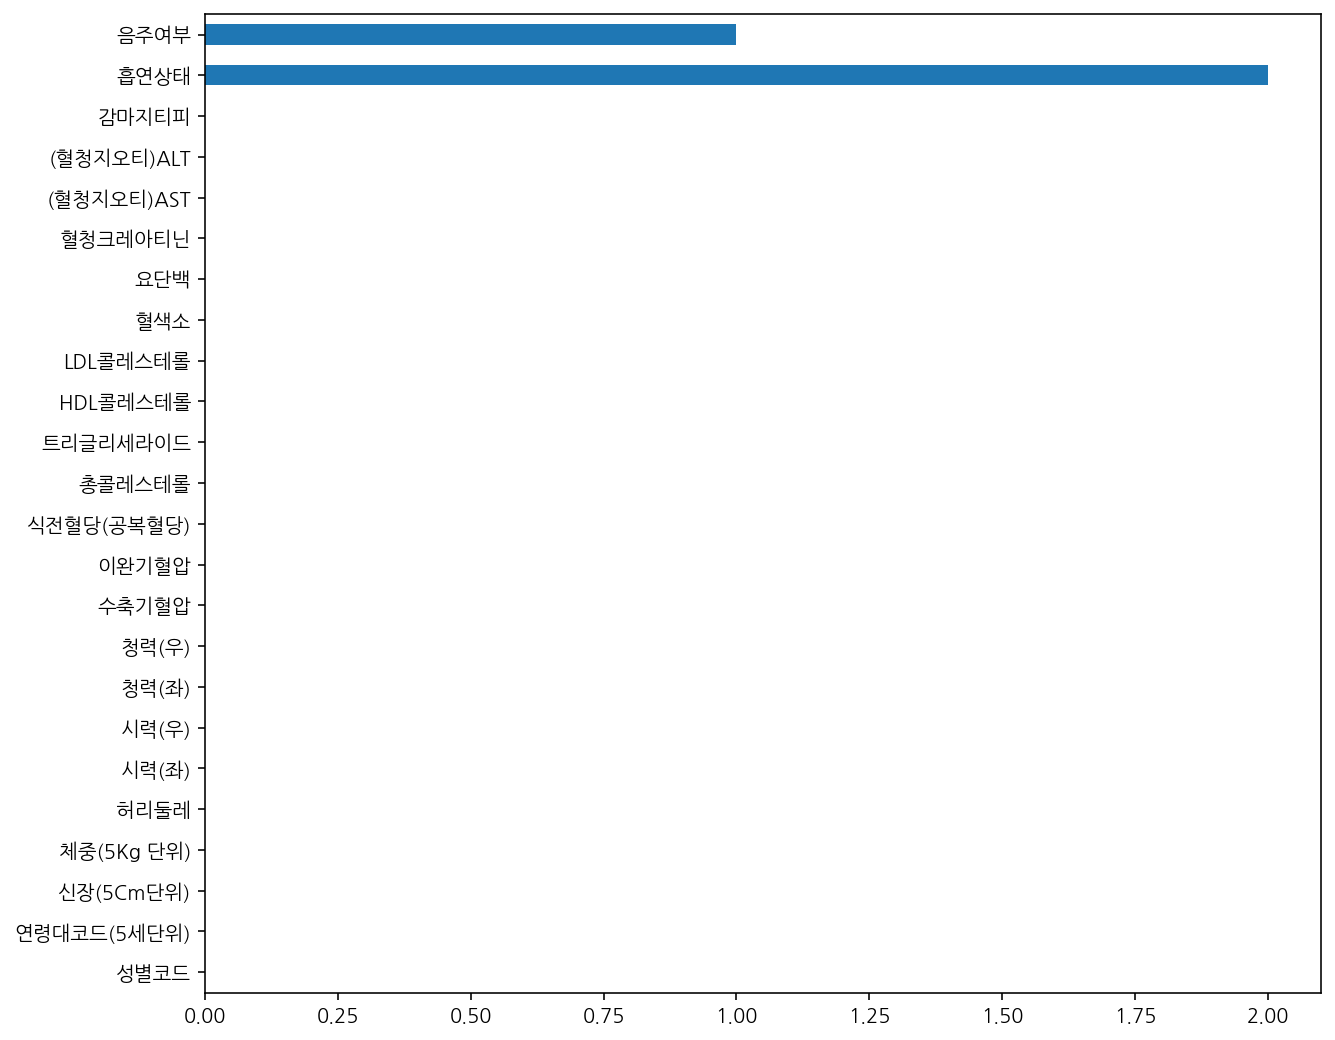

In [13]:
df_1.isnull().sum().plot.barh(figsize=(10, 9)) #결측치 확인

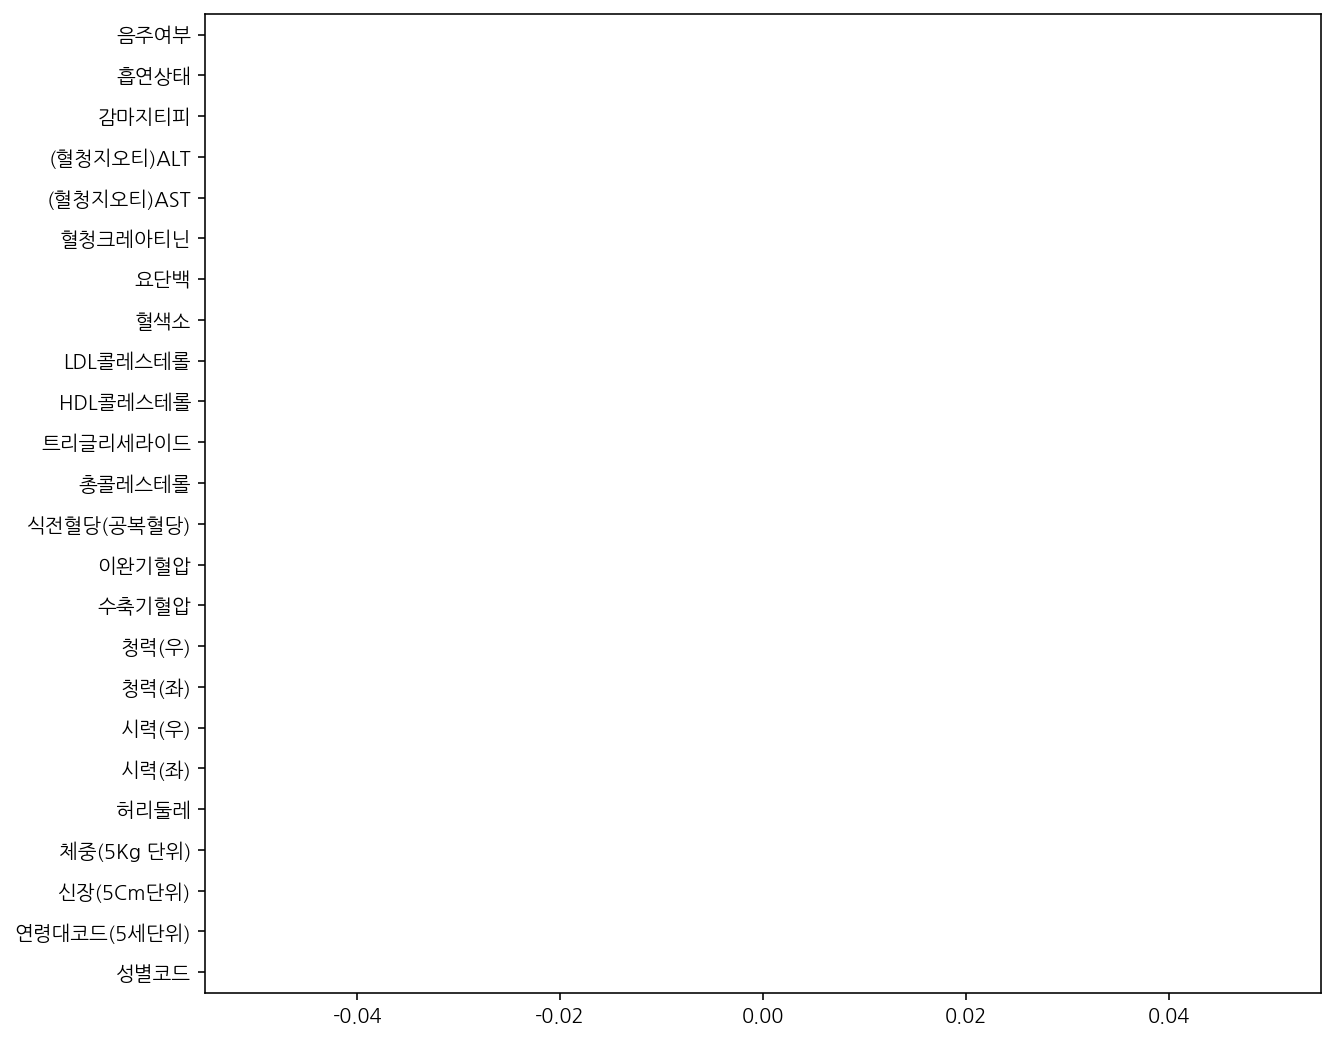

In [14]:
df_1 = df_1.dropna(axis=0) #음주 상태와 흡연 여부의 결측값은 적기 때문에 결측치가 있는 행을 삭제
df_1.isnull().sum().plot.barh(figsize=(10, 9)) #결측값이 없는 것을 확인

In [15]:
df_1['BMI'] = df_1['체중(5Kg 단위)'] / (df_1['신장(5Cm단위)']*df_1['신장(5Cm단위)']/10000)
#체질량 지수에 관한 열을 추가(BMI = 몸무게 / 신장(M)의 제곱)
#체중과 허리둘레보다는 조금 더 정확한 기준이 되지 않을까 예상

In [16]:
display(df_1.head()) #데이터 전처리가 완료된 데이터 헤드 확인

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI
0,M,9,165,60,72.1,1.2,1.5,1,1,127.0,...,118.0,15.0,1.0,1.1,21.0,27.0,21.0,No,No,22.038567
1,F,13,150,65,81.0,0.8,0.8,1,1,110.0,...,116.0,12.7,1.0,0.5,18.0,15.0,15.0,No,No,28.888889
2,F,12,155,55,70.0,0.6,0.7,1,1,123.0,...,116.0,12.8,1.0,0.7,27.0,25.0,7.0,No,No,22.892820
3,M,13,160,70,90.8,1.0,1.0,1,2,134.0,...,116.0,16.4,1.0,1.2,65.0,97.0,72.0,No,No,27.343750
4,F,12,155,50,75.2,1.5,1.2,1,1,144.0,...,133.0,12.4,1.0,0.7,18.0,17.0,14.0,No,No,20.811655


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd15a17850>,
      dtype=object)

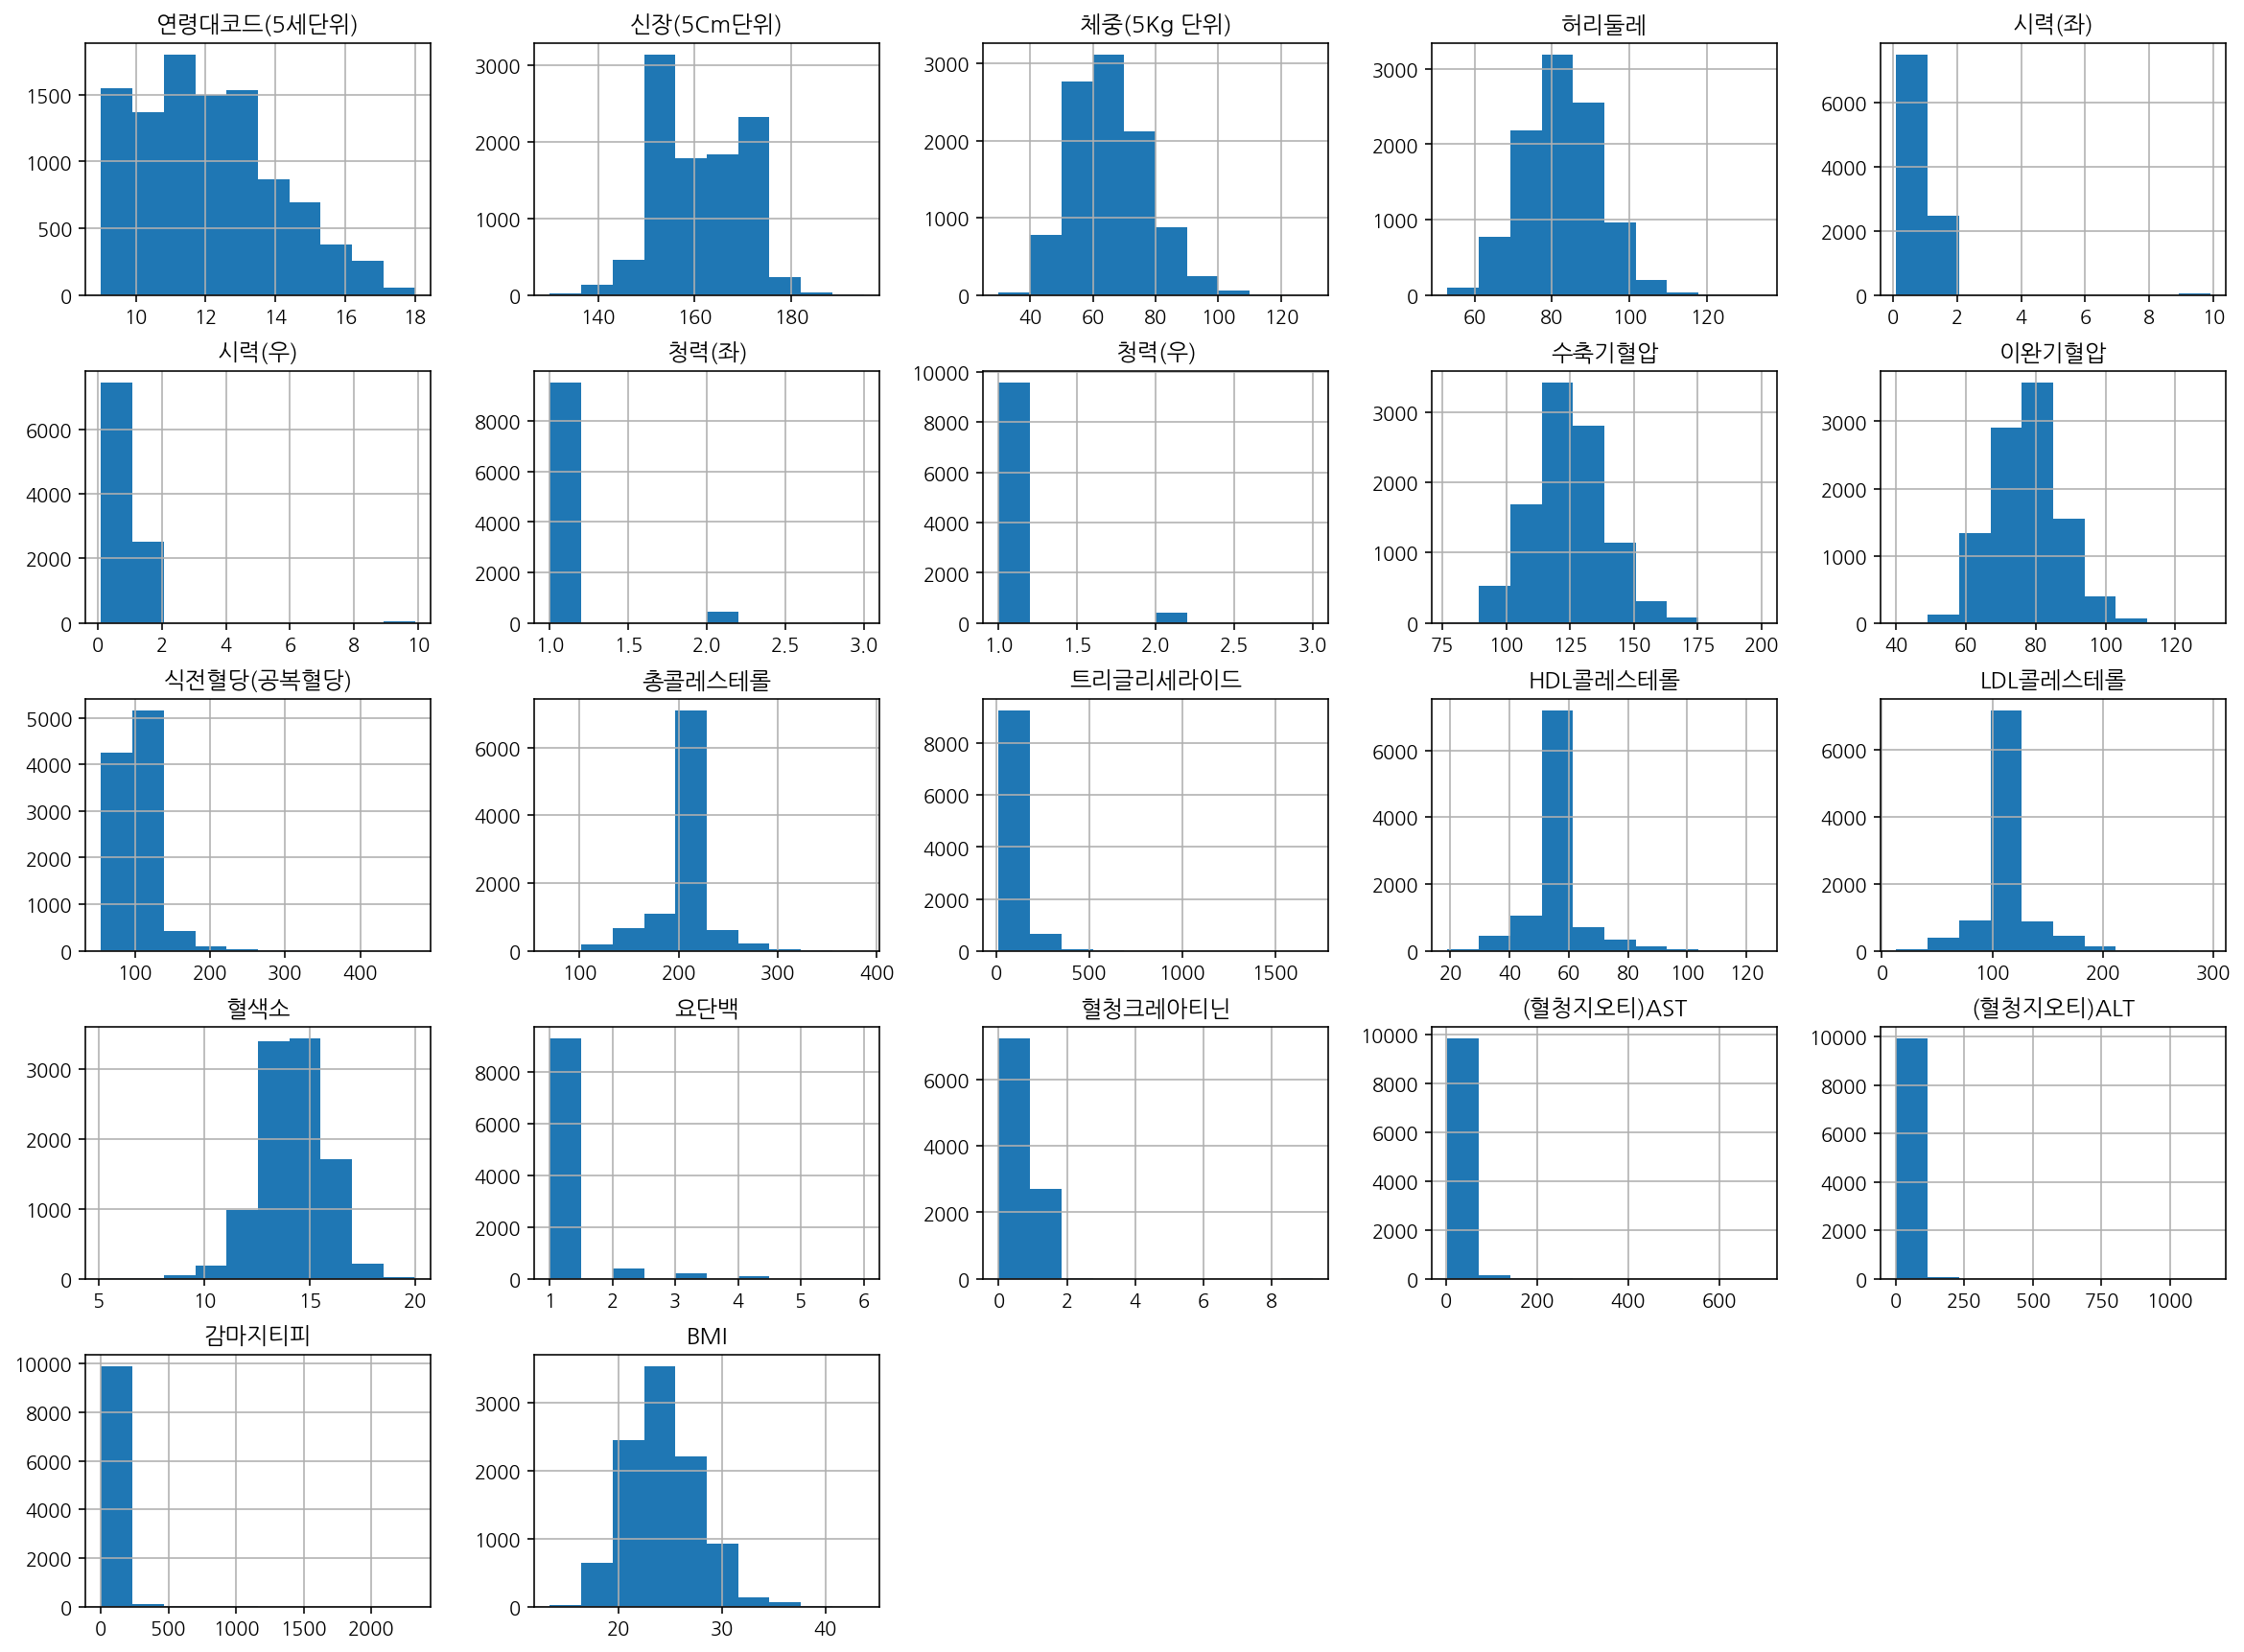

In [17]:
df_1.hist(bins=10, figsize=(20,15)) #숫자형 값의 전체적 분포 확인

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

Yes    5817
No     4180
Name: 음주여부, dtype: int64


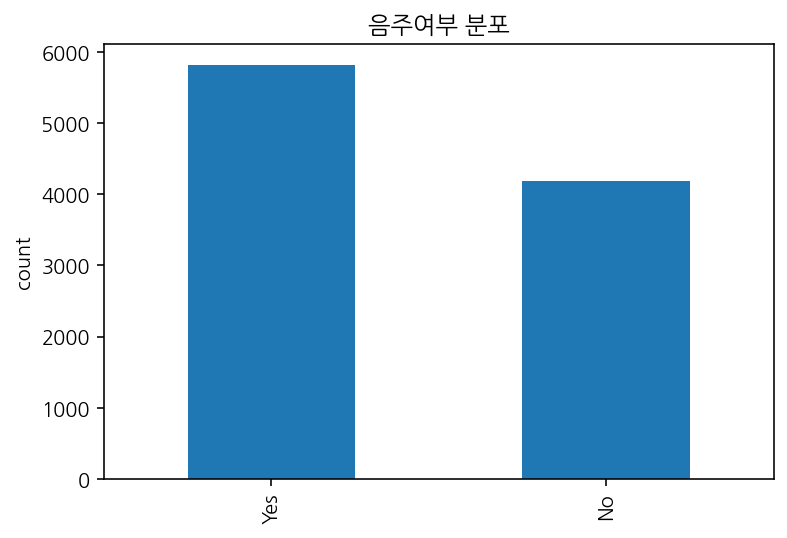

In [19]:
print(df_1['음주여부'].value_counts()) #음주여부의 분포를 확인

df_1['음주여부'].value_counts().plot.bar()
plt.ylabel('count')
plt.title('음주여부 분포')
plt.show()

#음주여부에 대한 긍정적인 답이 부정적 답보다 더 높아야 함

In [20]:
df_1["음주여부"] = df_1.음주여부.map({"No":0, "Yes":1})
df_1["흡연상태"] = df_1.흡연상태.map({"No":0, "Yes":1, "NotNow":2})
df_1["성별코드"] = df_1.성별코드.map({"M":0, "F":1})
#의사결정나무를 만들때, 스트링은 받아들일 수 없으므로 숫자로 바꿔 넣음

In [21]:
display(df_1.head())
display(df_1.tail())
#전처리가 완료된 데이터를 다시 한 번 위 아래로 확인

,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI
0,0,9,165,60,72.1,1.2,1.5,1,1,127.0,...,118.0,15.0,1.0,1.1,21.0,27.0,21.0,0,0,22.038567
1,1,13,150,65,81.0,0.8,0.8,1,1,110.0,...,116.0,12.7,1.0,0.5,18.0,15.0,15.0,0,0,28.888889
2,1,12,155,55,70.0,0.6,0.7,1,1,123.0,...,116.0,12.8,1.0,0.7,27.0,25.0,7.0,0,0,22.892820
3,0,13,160,70,90.8,1.0,1.0,1,2,134.0,...,116.0,16.4,1.0,1.2,65.0,97.0,72.0,0,0,27.343750
4,1,12,155,50,75.2,1.5,1.2,1,1,144.0,...,133.0,12.4,1.0,0.7,18.0,17.0,14.0,0,0,20.811655


,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,...,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,BMI
9995,1,13,155,55,83.0,1.2,1.2,1,1,120.0,...,116.0,13.7,1.0,0.7,20.0,21.0,20.0,0,1,22.892820
9996,1,11,160,55,77.5,1.0,1.2,1,1,132.0,...,116.0,14.3,1.0,0.7,24.0,22.0,21.0,0,1,21.484375
9997,0,12,160,80,93.0,0.6,0.6,1,1,116.0,...,116.0,15.6,1.0,1.0,22.0,27.0,35.0,0,0,31.250000
9998,1,15,155,55,78.0,0.6,1.0,1,1,117.0,...,116.0,13.5,1.0,1.0,26.0,24.0,21.0,0,0,22.892820
9999,1,13,160,75,100.0,0.5,0.5,1,1,120.0,...,86.0,13.3,1.0,0.6,32.0,24.0,30.0,2,1,29.296875


In [22]:
X = df_1.drop('음주여부', axis=1)  #음주여부를 제외한 24개의 설명변수를 사용
y = df_1.음주여부  #종속변수=음주여부

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

tree = DecisionTreeClassifier(random_state=0)  
tree.fit(X_train, y_train)
print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))
#첫번째 의사결정 나무는 과적합

학습용 데이터 정확도: 1.000
시험용 데이터 정확도: 0.631


In [23]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0) #깊이를 4로 제한, 시험용 데이터의 정확도가 상승함
tree.fit(X_train, y_train)

print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 0.717
시험용 데이터 정확도: 0.714


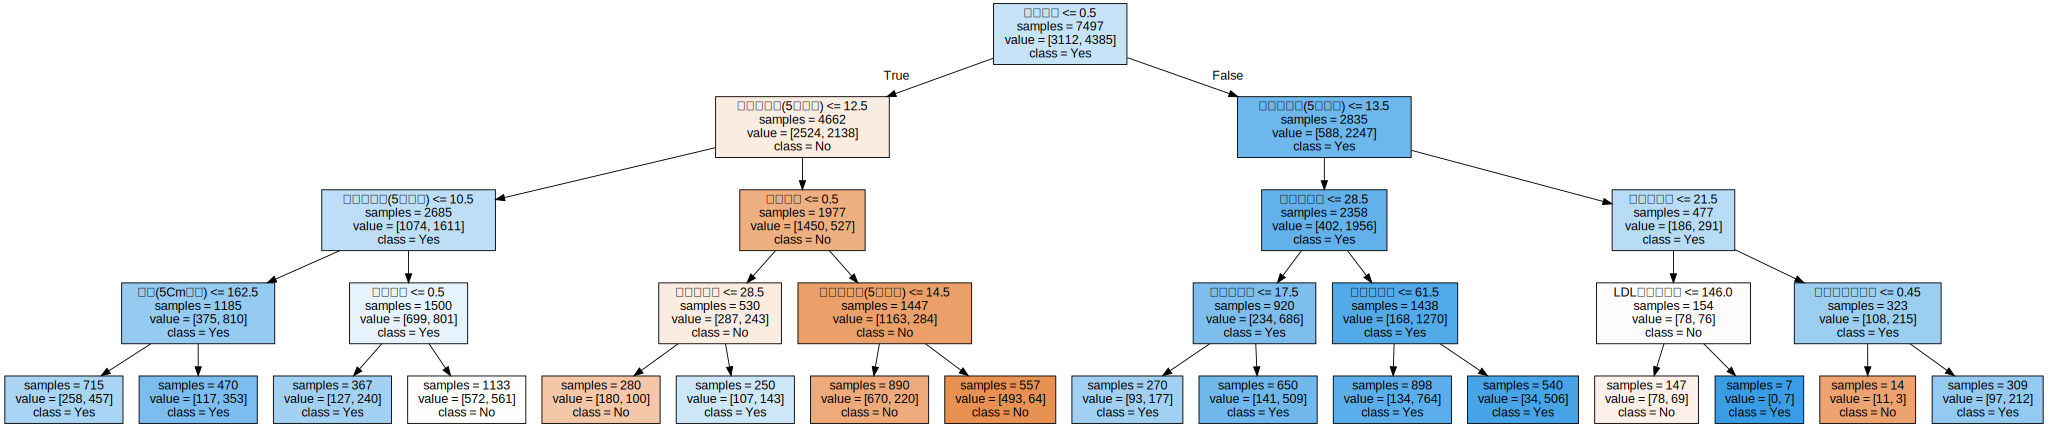

In [24]:
from sklearn.tree import export_graphviz #시각화
import graphviz

export_graphviz(tree, out_file="tree.dot", class_names=['No', 'Yes'],feature_names=X_train.columns, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

In [25]:
result = tree.feature_importances_
print("변수의 중요도:\n", result)

변수의 중요도:
 [0.07817266 0.38662842 0.00824621 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00436853 0.         0.
 0.00692281 0.         0.         0.05900091 0.45666046 0.        ]


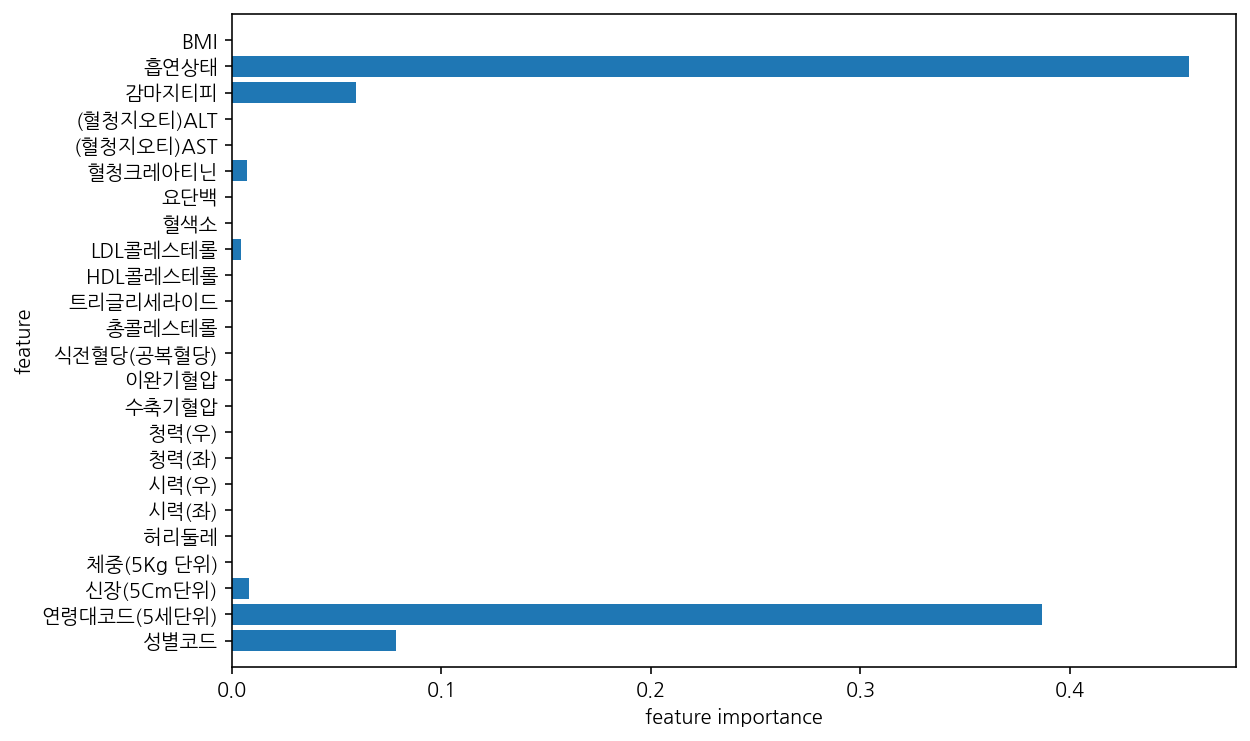

In [26]:
import numpy as np

def plot_feature_importances(model):
    plt.rcParams["figure.figsize"] = (9,6)
    n_features = len(X_train.columns)
    plt.barh(np.arange(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)

plot_feature_importances(tree)
#중요도에 있어서는 흡연상태와 연령대 코드가 나란히 높았다

In [27]:
res = pd.DataFrame(result)
res["name"] = X_train.columns
display(res.info())

#성별코드를 가장 많이, 연령대 코드를 두번째로 많이 사용하였다
display(res.sort_values(by='name'))  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       24 non-null     float64
 1   name    24 non-null     object 
dtypes: float64(1), object(1)
memory usage: 512.0+ bytes


None

,0,name
20,0.000000,(혈청지오티)ALT
19,0.000000,(혈청지오티)AST
23,0.000000,BMI
14,0.000000,HDL콜레스테롤
15,0.004369,LDL콜레스테롤
21,0.059001,감마지티피
0,0.078173,성별코드
9,0.000000,수축기혈압
6,0.000000,시력(우)
5,0.000000,시력(좌)


앙상블 - 랜덤 포레스트

In [28]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train.iloc[:, :], y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

In [29]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))
#랜덤 포레스트를 사용할 경우 역시 단일 의사결정 나무보다 정확도가 높았음을 확인 할 수 있었다

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.714


In [30]:
forest = RandomForestClassifier(n_estimators=400, random_state=0)
forest.fit(X_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))
#200으로 올렸을 때는 정확도가 크게 오르지 않아 4배 올려보았음
#0.005 정도 정확도가 오르는 것을 확인

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.719


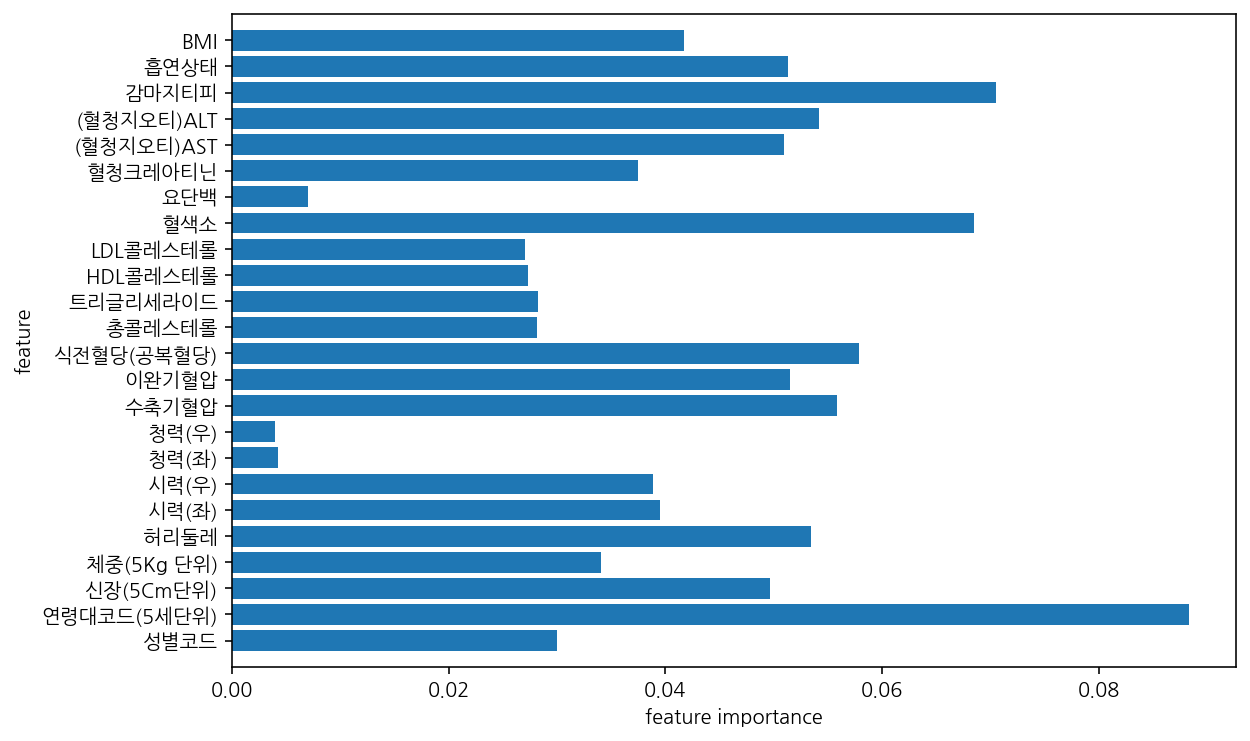

In [31]:
plot_feature_importances(forest)
#변수가 굉장히 많이 사용되었음
#요단백, 청력이 굉장히 낮은 빈도를 보임

In [47]:
from sklearn.model_selection import cross_val_score

# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
#교차 검증이 이루어질 때 높아지긴 하는데 0.7대에 그침

Accuracy
Decision tree:  [0.72533333 0.72533333 0.712      0.692      0.70533333 0.67866667
 0.72133333 0.69559413 0.70093458 0.70493992]
Random forest:  [0.736      0.712      0.71066667 0.69733333 0.708      0.696
 0.71733333 0.70894526 0.71562083 0.69826435]
Accuracy mean
Decision tree :0.706
Random forest :0.710


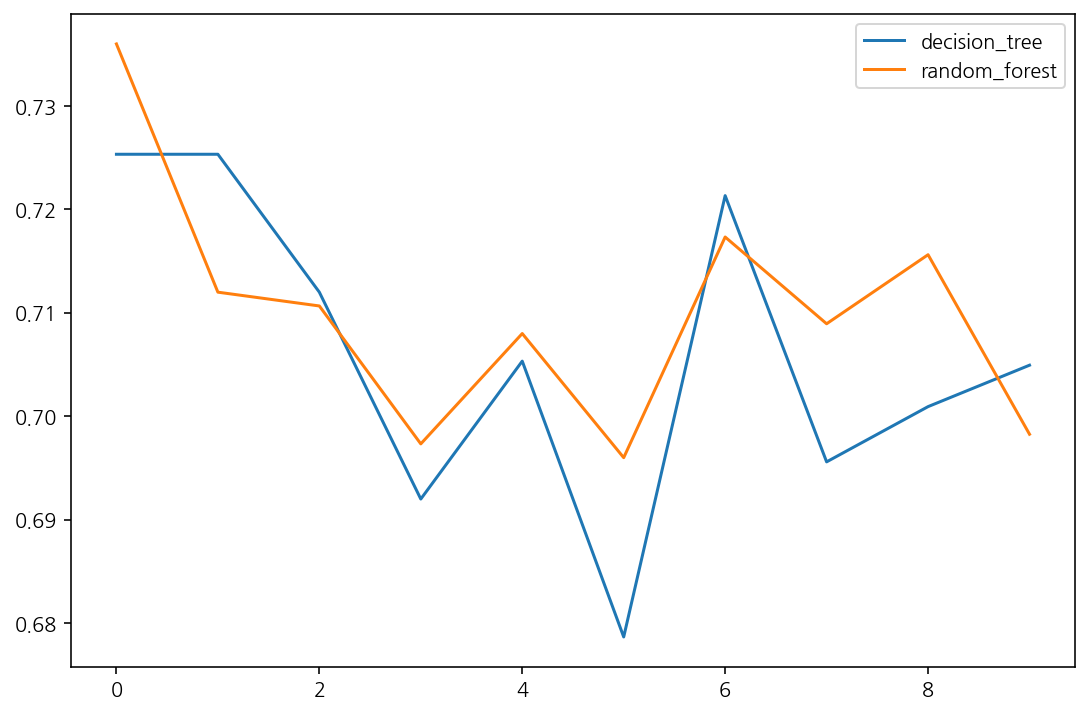

In [48]:
cv_list = [    
            ['decision_tree',dt_scores],
            ['random_forest',rf_scores],
          ]
df = pd.DataFrame.from_dict(dict(cv_list))
df.plot()
#대체로 랜덤 포레스트가 올라보이긴 하나 엇비슷함. 랜덤포레스트 보다는 그라디언트에 기대를 실음.

그라디언트 부스팅

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [35]:
print("학습용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))
#7.3대의 정확도 확인

학습용 데이터 세트 정확도: 0.754
시험용 데이터 세트 정확도: 0.727


In [36]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=4)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))
#깊이를 늘이니 정확도가 낮아짐

학습 데이터 세트 정확도: 0.777
시험용 데이터 세트 정확도: 0.723


In [37]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=2)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))
#깊이를 낮추니 정확도가 낮아짐
#가장 적절한 깊이는 3으로 확인

학습 데이터 세트 정확도: 0.733
시험용 데이터 세트 정확도: 0.727


In [38]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))
#학습률을 0.01로 제한하니 정확도가 낮아짐

학습 데이터 세트 정확도: 0.714
시험용 데이터 세트 정확도: 0.712


In [39]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.3)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))
#계속해서 학습률을 확인한 결과 0.3에서 정확도 7.3이 가장 높은 수치임을 확인함

학습 데이터 세트 정확도: 0.791
시험용 데이터 세트 정확도: 0.730


In [40]:
dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 
print("Gradient boosting: ", gbrt_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 
#전체적으로 정확도를 비교
#랜덤 포레스트와 그라디언트가 같은 정확도를 보였지만, 학습률과 깊이 제한에 있어서는
#그라디언트가 더 높은 정확도를 보인다 판단

Accuracy
Decision tree:  [0.72533333 0.72533333 0.712      0.692      0.70533333 0.67866667
 0.72133333 0.69559413 0.70093458 0.70493992]
Random forest:  [0.736      0.712      0.71066667 0.69733333 0.708      0.696
 0.71733333 0.70894526 0.71562083 0.69826435]
Gradient boosting:  [0.728      0.72133333 0.71733333 0.712      0.70133333 0.676
 0.728      0.70093458 0.71161549 0.70360481]
Accuracy mean
Decision tree :0.706
Random forest :0.710
Gradient boosting :0.710


In [41]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[1,2,3,4], 'learning_rate':[0.3,0.1,0.08, 0.06, 0.04, 0.02]} #아까 수치를 변경하면서 넣었던 깊이와 정확도를 추가하였음

In [42]:
 
init_gbrt = GradientBoostingClassifier(random_state=0)
grid_gbrt = GridSearchCV(init_gbrt, param_grid=parameters, cv=3, refit=True)
print(grid_gbrt)

grid_gbrt.fit(X_train, y_train)


scores_df = pd.DataFrame(grid_gbrt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]
#아까 수치를 변경하면서 예측했던 것과는 달리, 학습률이 0.02~0.04로 낮을 때, 그리고 깊이가 2일 때 가장 높은 정확도를 보인다는 결과가 나옴

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.3, 0.1, 0.08, 0.06, 0.04, 0.02],
                         'max_depth': [1, 2, 3, 4]})


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.3, 'max_depth': 1}",0.718021,11,0.727891,0.711084,0.715086
1,"{'learning_rate': 0.3, 'max_depth': 2}",0.715353,17,0.719088,0.712285,0.714686
2,"{'learning_rate': 0.3, 'max_depth': 3}",0.705082,23,0.715886,0.694278,0.705082
3,"{'learning_rate': 0.3, 'max_depth': 4}",0.696679,24,0.704282,0.690276,0.695478
4,"{'learning_rate': 0.1, 'max_depth': 1}",0.716687,15,0.723089,0.710684,0.716287
5,"{'learning_rate': 0.1, 'max_depth': 2}",0.718687,8,0.723489,0.715486,0.717087
6,"{'learning_rate': 0.1, 'max_depth': 3}",0.714152,20,0.716287,0.708683,0.717487
7,"{'learning_rate': 0.1, 'max_depth': 4}",0.711751,22,0.715086,0.707083,0.713085
8,"{'learning_rate': 0.08, 'max_depth': 1}",0.717354,13,0.724690,0.711485,0.715886
9,"{'learning_rate': 0.08, 'max_depth': 2}",0.720288,3,0.726291,0.715086,0.719488


In [43]:
print('GridSearchCV 최적 파라미터:', grid_gbrt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_gbrt.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.06, 'max_depth': 2}
GridSearchCV 최고 정확도: 0.7210


In [44]:
# 최적 파라미터로 학습이 된 모델을 이용하여 시험용 데이터 세트 분류
print("시험용 데이터 세트 정확도: {:.3f}".format(grid_gbrt.score(X_test, y_test)))

시험용 데이터 세트 정확도: 0.723


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 

print(y_test.value_counts()) 

1    1432
0    1068
Name: 음주여부, dtype: int64


In [46]:
dt_pred = tree.predict(X_test)
rf_pred = forest.predict(X_test)
grid_gbrt_pred = grid_gbrt.predict(X_test)

print('Decision tree 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, dt_pred)))
print(confusion_matrix(y_test, dt_pred))
print('Random forest 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, rf_pred)))
print(confusion_matrix(y_test, rf_pred))
print('Gradient boosting 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, grid_gbrt_pred)))
print(confusion_matrix(y_test, grid_gbrt_pred))
#그라디언트 부스팅이 가장 높은 정확도로 적절한 모델이지만, 정확도가 0.7대로 개선의 여지가 보임

Decision tree 시험용 데이터 세트 정확도:0.714
[[ 690  378]
 [ 337 1095]]
Random forest 시험용 데이터 세트 정확도:0.719
[[ 589  479]
 [ 224 1208]]
Gradient boosting 시험용 데이터 세트 정확도:0.723
[[ 588  480]
 [ 213 1219]]


인사이트
1. 음주를 판별하는 데 성별 코드, 흡연 여부, 나이 코드는 꽤나 유의미하게 쓰인다
2. 의외로 음주로 인해 영향을 받을 것이라 생각했던 간 수치 관련 데이터(콜레스테롤 등)은 음주여부 판별에 영향을 크게 주지 않았음
3. BMI는 거의 사용되지 않음, 음주 여부 판별에 영향력이 거의 없었음
4. 따라서 음주 여부의 판별에는 나이, 성별, 흡연 여부가 우선적으로 사용되고, 세부적으로 신체 데이터가 사용된다고 판단할 수 있다


5. 건강검진 데이터 만으로는 음주 여부를 정확히 판별하는 데에 어려움이 있었다. 더 많은 데이터가 필요할 듯 싶다.


6. 가장 최적의 모델은 의사결정나무 - 그라디언트 부스팅(앙상블) : 깊이 2에 학습률 0.06이었다.

